# Chapter 16 - Natural Language Processing with RNNs and Attention

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dongdongdongdong/anaconda3/lib/python3.6/s

In [3]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Generating Shakespeaream Text using a Character RNN

## Creating the Training Dataset

### Spliting a sequence into batches of shuffled windows:

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g., [0, 1, 2, 3, 4], [2, 3, 4, 5, 6], etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., [2, 3, 4, 5, 6] would be split into [[2, 3, 4, 5], [3, 4, 5, 6]]), then create batches of 3 such input/target pairs:

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
n_steps = 5

dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [6]:
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)

In [7]:
for index, (X_batch, Y_batch) in enumerate(dataset):
    print('_' * 20, 'Batch', index, '\nX_batch')
    print(X_batch.numpy())
    print('=' * 5, '\nY_batch')
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


### Loading the Data and Preparing the Dataset:

In [8]:
shakespear_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

In [9]:
filepath = keras.utils.get_file('shakespear.txt', shakespear_url)

with open(filepath) as f:
    shakespear_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [10]:
print(shakespear_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [11]:
''.join(sorted(set(shakespear_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [12]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespear_text)

In [13]:
tokenizer.texts_to_sequences(['First'])

[[20, 6, 9, 8, 3]]

In [14]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [15]:
max_id = len(tokenizer.word_index) # number of distinct characters
max_id

39

In [16]:
dataset_size = tokenizer.document_count # total number of characters
dataset_size

1115394

In [17]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespear_text])) - 1

### How to Split a Sequential Dataset:

In [19]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [20]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead

In [21]:
dataset = dataset.repeat().window(window_length, 
                                  shift=1, 
                                  drop_remainder=True)

Convert a nested dataset into a *flat dataset*:

In [22]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

Shuffle the dataset to get independence:

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
batch_size = 32

dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [25]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [26]:
dataset = dataset.prefetch(1)

In [27]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Building and Training the Char-RNN Model

In [28]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True,
                     input_shape=[None, max_id],
                     dropout=0.2,
                     recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2,
                     recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation='softmax'))
])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [29]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_gru (UnifiedGRU)     (None, None, 128)         64896     
_________________________________________________________________
unified_gru_1 (UnifiedGRU)   (None, None, 128)         99072     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 39)          5031      
Total params: 168,999
Trainable params: 168,999
Non-trainable params: 0
_________________________________________________________________


## Using the Modle to Generate Text

In [31]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [ ]:
X_new = preprocess(['How are yo'])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

## Generating Fake Shakespearean Texts

In [32]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), 
                        np.log(0.4), 
                        np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

In [33]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

In [34]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

In [ ]:
print(complete_text("t", temperature=1))

In [ ]:
print(complete_text("t", temperature=2))

## Stateful RNN

In [35]:
tf.random.set_seed(42)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length,
                         shift=n_steps,
                         drop_remainder=True)
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch,
                                         depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
batch_size = 32

encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []

for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
    
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [38]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [39]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam")

steps_per_epoch = train_size // batch_size // n_steps

history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [40]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, 
                     input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [41]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [42]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

## Sentiment Analysis

In [43]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}

for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

In [49]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", 
                           as_supervised=True, 
                           with_info=True)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Shuffling and writing examples to /Users/dongdongdongdong/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4HTNHS/imdb_reviews-train.tfrecord


A Jupyter Widget

A Jupyter Widget

Shuffling and writing examples to /Users/dongdongdongdong/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4HTNHS/imdb_reviews-test.tfrecord


A Jupyter Widget

A Jupyter Widget

Shuffling and writing examples to /Users/dongdongdongdong/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4HTNHS/imdb_reviews-unsupervised.tfrecord


A Jupyter Widget

Dataset imdb_reviews downloaded and prepared to /Users/dongdongdongdong/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [50]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [53]:
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

In [55]:
train_size, test_size

(25000, 25000)

In [57]:
for X_batch, y_batch in datasets['train'].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print('Review:', review.decode('utf-8')[:200], '...')
        print('Label:', label, '= Positive' if label else '= Negative')
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



### Preprocessing:

In [60]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300) # keep only the first 300 char
    X_batch = tf.strings.regex_replace(X_batch, rb'<br\s*/?>', b' ')
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b' ')
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [ ]:
preprocess(X_batch, y_batch)

In [ ]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common()[:3]

In [ ]:
len(vocabulary)

In [ ]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [ ]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

### Create a Lookup Table:

In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

### Creta the Final Dataset:

In [ ]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [ ]:
embed_size = 128

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, 
                           embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Or using manual masking:

In [ ]:
K = keras.backend

embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)

z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)

outputs = keras.layers.Dense(1, activation="sigmoid")(z)

model = keras.models.Model(inputs=[inputs], outputs=[outputs])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

## Reusing Pretrained Embeddings

For example, let's use the `nnlm-en-dim50` sentence embedding model, version 1, in our sentiment analysis model:

In [ ]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

## An Encoder-Decoder Network for Neural Machine Translation

In [65]:
tf.random.set_seed(42)

In [66]:
vocab_size = 100
embed_size = 10

In [ ]:
import tensorflow_addons as tfa

In [ ]:
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam")

In [ ]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)

X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

## Bidirectional Recurrent Layers

In [69]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True,
                     input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

In [70]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_gru_6 (UnifiedGRU)   (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


## Positional Embeddings

In [77]:
class PositionalEncoding(keras.layers.Layer):
    
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 ==1:
            max_dims += 1
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embdeeing = tf.constant(pos_emb.astype(self.dtype))
        
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embdeeing[:, :shape[-2], :shape[-1]]

In [78]:
max_steps = 201
max_dims = 512

pos_emb = PositionalEncoding(max_steps=max_steps, max_dims=max_dims)

In [79]:
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

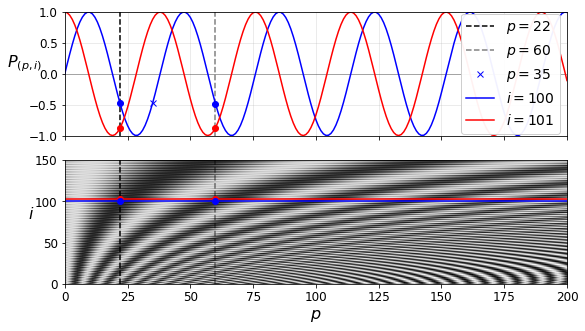

In [80]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [81]:
embed_size = 512; max_steps = 500; vocab_size = 10000

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)

encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)

encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [ ]:
Z = encoder_in

for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])
    
encoder_outputs = Z

Z = encoder_in

for N in range(6):
    Z = keras.layers.Attention(use_scale=True,
                               causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])
    
outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation='softmax'))(Z)

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [82]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    
    def __init__(self, n_heads, causal=True, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads * 3] # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims,
                                            kernel_size=1,
                                            use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, 
                                            kernel_size=1, 
                                            use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, 
                                            kernel_size=1, 
                                            use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, 
                                                use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, 
                                              kernel_size=1, 
                                              use_bias=False)
        super().build(batch_input_shape)
        
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [ ]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape